epoch  0 training accuracy 0.49
epoch  1 training accuracy 0.59
epoch  2 training accuracy 0.64
epoch  3 training accuracy 0.68
epoch  4 training accuracy 0.70
epoch  5 training accuracy 0.72
epoch  6 training accuracy 0.74
epoch  7 training accuracy 0.75
epoch  8 training accuracy 0.76
epoch  9 training accuracy 0.77
epoch  10 training accuracy 0.78
epoch  11 training accuracy 0.79
epoch  12 training accuracy 0.80
epoch  13 training accuracy 0.80
epoch  14 training accuracy 0.81
epoch  15 training accuracy 0.81
epoch  16 training accuracy 0.82
epoch  17 training accuracy 0.82
epoch  18 training accuracy 0.83
epoch  19 training accuracy 0.83
epoch  20 training accuracy 0.83
epoch  21 training accuracy 0.84
epoch  22 training accuracy 0.84
epoch  23 training accuracy 0.84
epoch  24 training accuracy 0.85
epoch  25 training accuracy 0.85
epoch  26 training accuracy 0.85
epoch  27 training accuracy 0.85
epoch  28 training accuracy 0.86
epoch  29 training accuracy 0.86
epoch  30 training a

epoch  245 training accuracy 0.95
epoch  246 training accuracy 0.95
epoch  247 training accuracy 0.95
epoch  248 training accuracy 0.95
epoch  249 training accuracy 0.95


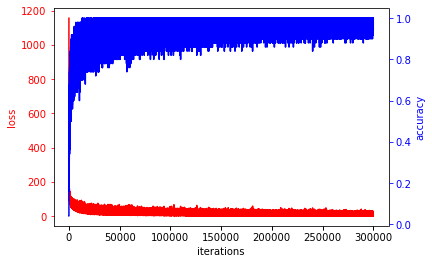


-------------

EVALUATE TEST DATA

Testing Accuracy 0.99


In [1]:
import torch as T
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

def one_hot_enc(y, num_labels=10):
    one_hot = T.zeros(num_labels, y.shape[0])

    for i, val in enumerate(y):
        one_hot[val,i] = 1.0

    return one_hot

def add_bias_unit(layer, orientation):
    if orientation == 'row':
        new_layer = T.ones((layer.shape[0]+1, layer.shape[1]))
        new_layer[1:, :] = layer
    elif orientation == 'col':
        new_layer = T.ones((layer.shape[0], layer.shape[1] + 1))
        new_layer[:, 1:] = layer

    return new_layer

def init_weights(n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
    w1 = T.randn((n_hidden_1, n_input+1), dtype=T.float)
    w2 = T.randn((n_hidden_2, n_hidden_1+1), dtype=T.float)
    w3 = T.randn((n_output, n_hidden_2+1), dtype=T.float)

    return w1, w2, w3

def compute_forward_pass(input, w1, w2, w3):
    a1 = T.reshape(input, shape=(input.shape[0], -1))
    a1 = add_bias_unit(a1, orientation='col')

    z2 = w1.matmul(T.transpose(a1, 0, 1))
    a2 = T.sigmoid(z2)
    a2 = add_bias_unit(a2, orientation='row')

    z3 = w2.matmul(a2)
    a3 = T.sigmoid(z3)
    a3 = add_bias_unit(a3, orientation='row')

    z4 = w3.matmul(a3)
    a4 = T.sigmoid(z4)

    return a1, z2, a2, z3, a3, z4, a4

def predict(a4):
    prediction = T.argmax(a4, dim=0)

    return prediction

def compute_loss(prediction, label):
    term_1 = -1*label * T.log(prediction)
    term_2 = (1-label)*(T.log(1-prediction))

    loss = T.sum(term_1 - term_2)
    return loss

def compute_backward_pass(weights, outputs, label):
    w1, w2, w3 = weights
    a1, z2, a2, z3, a3, z4, a4 = outputs

    delta_4 = a4 - label
    delta_3 = T.transpose(w3[:,1:], 0,1).matmul(delta_4)*\
             T.sigmoid(z3)*(1-T.sigmoid(z3))
    delta_2 = w2[:,1:].matmul(delta_3)*T.sigmoid(z2)*(1-T.sigmoid(z2))

    grad_w1 = delta_2.matmul(a1)
    grad_w2 = delta_3.matmul(T.transpose(a2,0,1))
    grad_w3 = delta_4.matmul(T.transpose(a3,0,1))

    return grad_w1, grad_w2, grad_w3

def get_data(train_batch_size, test_batch_size=10):
    mnist_train_data = MNIST('mnist',
                             train=True, download=True, transform=ToTensor())
    train_data_loader = T.utils.data.DataLoader(mnist_train_data,
                                                batch_size=train_batch_size,
                                                shuffle=True,
                                                num_workers=8)
    mnist_test_data = MNIST('mnist',
                            train=False, download=True, transform=ToTensor())
    test_data_loader = T.utils.data.DataLoader(mnist_test_data,
                                                batch_size=test_batch_size,
                                                shuffle=True,
                                                num_workers=8)
    return train_data_loader, test_data_loader

if __name__ == '__main__':
    batch_size = 50
    n_input = 28*28

    n_hidden_1, n_hidden_2, n_output = 100, 100, 10
    w1, w2, w3 = init_weights(n_input, n_hidden_1, n_hidden_2,
                                n_output, batch_size)

    eta = 0.001 # learning rate
    alpha = 0.001 # momentum factor
    num_epochs = 250

    delta_w1_prev = T.zeros(w1.shape)
    delta_w2_prev = T.zeros(w2.shape)
    delta_w3_prev = T.zeros(w3.shape)

    train_losses = []
    train_acc = []

    train_data, test_data = get_data(batch_size)

    for i in range(num_epochs):
        for j, (input, label) in enumerate(train_data):
            one_hot_label = one_hot_enc(label, num_labels=10)
            a1, z2, a2, z3, a3, z4, a4 = compute_forward_pass(input, w1,w2,w3)
            loss = compute_loss(a4, one_hot_label.float())
            grad1, grad2, grad3 = compute_backward_pass([w1, w2, w3],
                                            [a1, z2, a2, z3, a3, z4, a4],
                                            one_hot_label.float())

            delta_w1, delta_w2, delta_w3 = eta*grad1, eta*grad2, eta*grad3

            w1 -= delta_w1 + delta_w1_prev*alpha
            w2 -= delta_w2 + delta_w2_prev*alpha
            w3 -= delta_w3 + delta_w3_prev*alpha

            delta_w1_prev, delta_w2_prev, delta_w3_prev = \
                                                    delta_w1, delta_w2, delta_w3

            train_losses.append(loss)
            predictions = predict(a4)

            wrong = T.where(predictions != label,
                            T.tensor([1.]), T.tensor([0.]))
            accuracy = 1 - T.sum(wrong)/batch_size
            train_acc.append(accuracy.float())

        print('epoch ', i, 'training accuracy %.2f' %
                T.mean(T.tensor(train_acc)).item())

    fig = plt.figure()
    ax = fig.add_subplot(111, label='1')
    ax2 = fig.add_subplot(111, label='2', frame_on=False)
    ax.plot(train_losses, color='red')
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss', color='red')
    ax.tick_params(axis='y', colors="red")
    ax2.plot(train_acc, color='blue')
    ax2.yaxis.tick_right()
    ax2.set_ylabel('accuracy', color='blue')
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="blue")
    ax2.set_xticklabels([])
    plt.show()

    print('\n-------------\n')
    print('EVALUATE TEST DATA\n')

    test_acc = []
    for j, (input, label) in enumerate(test_data):
        one_hot_label = one_hot_enc(label, num_labels=10)
        a1, z2, a2, z3, a3, z4, a4 = compute_forward_pass(input,w1,w2,w3)
        loss = compute_loss(a4, one_hot_label.float())

        predictions = predict(a4)
        wrong = T.where(predictions != label, T.tensor([1.]), T.tensor([0.]))
        accuracy = 1 - T.sum(wrong)/batch_size

        test_acc.append(accuracy)

    print('Testing Accuracy %.2f' % T.mean(T.tensor(test_acc)).item())